The following code was generated in Spyder as part of the Anaconda distribution. I've included this notebook to provide my reasons and thoughts on this exercise.

In [51]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [52]:
##Import datasets and modify them##
train_data = pd.read_csv('intern_data.csv')
test_data = pd.read_csv('intern_test.csv')
del(train_data['Unnamed: 0'])
del(test_data['Unnamed: 0'])

#Replace 'string' data with floats#
mapping_c = {'green':0,'red':1,'yellow':2,'blue':3}
mapping_h = {'white':0,'black':1}
train_data = train_data.replace({'c':mapping_c,'h':mapping_h})
train_data['c'] = train_data['c'].astype(float)
train_data['h'] = train_data['h'].astype(float)

test_data = test_data.replace({'c':mapping_c,'h':mapping_h})
test_data['c'] = test_data['c'].astype(float)
test_data['h'] = test_data['h'].astype(float)

del(mapping_c,mapping_h)

The following graphs are part of my exploratory data analysis. On the first graph, I reduced the dimensions of the data using the t-SNE model and found some definite clusters. From this information, I focused on algorithms that could handle oddly shaped decision boundaries.

In the second graph, I squared the values of the first graph to determine if the data was linearly separable in another dimension.

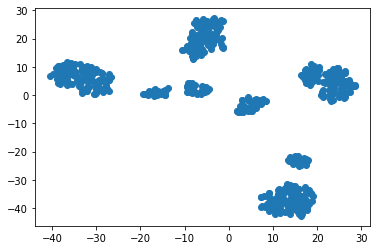

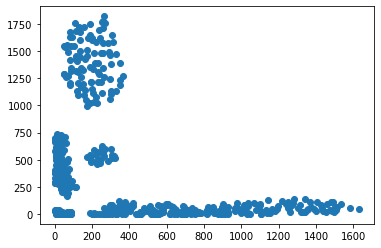

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24c69310>


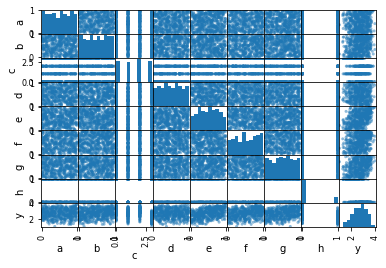

In [53]:
##Use the TSNE model to reduce the dimensions of teh data and visualize how##
##the variables are distributed##
model = TSNE()
model_transformed = model.fit_transform(train_data)
xs = model_transformed[:,0]
ys = model_transformed[:,1]
plt.scatter(xs,ys)
plt.show()

#Transform the data points to see if we can find a linear relationship# 
#amongst the clusters#
plt.scatter(np.square(xs),np.square(ys))
plt.show()

##Determine if there are correlations between variables in the data##
eda = pd.plotting.scatter_matrix(train_data)
print(eda)
del(eda)

In the above graph, I did not find a strong correlation between any two variables. The y variable in the bottom right corner looks to have a slightly skewed normal distribution, while most of the other data points appear to come from the uniform distribution.

In [54]:
##Partition the training set into target and feature variables##
train_y = pd.DataFrame(train_data['y'])
del(train_data['y'])

#Split the training set to test the linear regression model later#
x_train,x_test,y_train,y_test = train_test_split(train_data,train_y,
                                                 test_size = 0.1,random_state = 12)


SVR Training Score:  0.9755891285438777

SVR Test Score:  0.9721807649190385

5-Fold Cross Validation Scores:  [0.95181274 0.96084703 0.95291211 0.96564706 0.95094435]


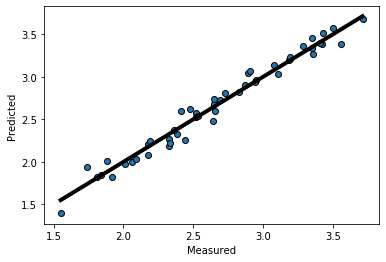

In [55]:
##Run a regression model using a Support Vector Machine on the training set##
##and check its accuracy##
svr = SVR(kernel = 'rbf',gamma = 0.5)
svr_predict = svr.fit(x_train,y_train).predict(x_test)
print("\nSVR Training Score: ", svr.score(x_train,y_train))
print("\nSVR Test Score: ", svr.score(x_test,y_test))

#Cross-Validation Score of the SVR#
cvs = cross_val_score(svr, train_data, train_y, cv = 5)
print("\n5-Fold Cross Validation Scores: ", cvs)

#Plot the tru target values against the predicted ones to visualize#
#how well the regression model did#
fig, ax = plt.subplots()
ax.scatter(y_test, svr_predict, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

del(x_train,y_train,x_test,y_test)
del(ax,fig)

I chose the Support Vector Machine due to the t-SNE model earlier which showed definite clustering. I could probably play with the gamma value a little more, but I saw a significant decrease in accuracy at both 0.1 and 1.0. Overall, I'm happy with the results.

In [56]:
##Use the regression model to predict the target values for the test set##
svr.fit(train_data,train_y)
prediction = svr.predict(test_data).tolist()

#This bit is just so I can combine the indices of the test set with the#
#predictions#  
test_data = pd.read_csv('intern_test.csv')
prediction_final = pd.DataFrame(test_data['Unnamed: 0'])
prediction_final.columns = ['i']
prediction_final['y'] = prediction
prediction_final.set_index('i', inplace = True)

#Export to a .csv file#
prediction_final.to_csv('intern_predicted.csv')